# Probabilistic Count Matrix Factorization on real scRNA-seq data

We want to find a way of expressing the assumption that dropout rates are linked with library size. To do this, we infer the parameters of a pCMF on a real scRNA-seq data set and check if there are any properties in V or in U that can be exploited.

In [1]:
%matplotlib inline

import sys
sys.path.insert(0, '../')
import utils, cavi_new, svi_new, svi_hpcmf
import plot_utils

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score
import pandas as pd
from scipy.stats import gamma

import operator

plt.style.use('ggplot')

# Data loading

In [2]:
#X = pd.read_csv('../../Datasets/scRNA-seq/reference_data/BISCUIT/zeisel/expression_mRNA_17-Aug-2014.txt', sep='\t')
X = pd.read_csv('../../Datasets/scRNA-seq/reference_data/BISCUIT/zeisel/expression_mRNA_17-Aug-2014.txt', sep="\t", low_memory=False).T

In [3]:
clusters = np.array(X[7], dtype=str)[2:]
cluster_names, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression_data = np.array(X, dtype=np.int)[1:]

# keep the most variable genes according to the Biscuit ICML paper
selected = np.std(expression_data, axis=0).argsort()[-558:][::-1]
expression_data = expression_data[:, selected]
gene_names = gene_names[selected].astype(str)

In [4]:
Y = expression_data

In [5]:
cluster_names, labels = np.unique(clusters, return_inverse=True)

In [6]:
Y.shape

(3005, 558)

In [7]:
# Experiment parameters
N = Y.shape[0] # number of observations
P = Y.shape[1] # observation space dimensionality
K = 10 # latent space dimensionality
C = cluster_names.size # number of clusters

T = 480.
S = 1.

# Run PCA
pca_U = PCA(n_components=10).fit_transform(np.log(Y + 1))
pca_U = TSNE(n_components=2).fit_transform(pca_U)


# Run SVI and get estimates (pCMF)
alpha = np.ones((2, K))
alpha[0, :] = 3.
alpha[1, :] = 0.5
beta = np.ones((2, P, K))
pi = np.ones((P,)) * 0.5
print('SPCMF:')
inf = svi_new.StochasticVI(Y, alpha, beta, pi)
spcmf_ll = inf.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
spcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
spcmf_U = TSNE(n_components=2).fit_transform(spcmf_U)

# print('\n')

# # Run SVI and get estimates (hpCMF)
# alpha = np.ones((2, K))
# alpha[0, :] = 3.
# alpha[1, :] = 0.5
# beta = np.ones((2, P, K))
# pi = np.ones((P,)) * 0.5
# print('SHPCMF:')
# inf = svi_hpcmf.StochasticVI(Y, alpha, beta, pi)
# shpcmf_ll = inf.run_svi(n_iterations=4000, minibatch_size=100, return_ll=True, sampling_rate=S, max_time=T)
# shpcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
# shpcmf_U = TSNE(n_components=2).fit_transform(shpcmf_U)

SPCMF:


In [37]:
T = 60.*10.

spcmf_ll = inf.run_svi(n_iterations=4000, minibatch_size=100, empirical_bayes=True, return_ll=True, sampling_rate=S, max_time=T)
spcmf_U = inf.a[0] / inf.a[1] # VI estimate is the mean of the variational approximation
spcmf_U = TSNE(n_components=2).fit_transform(spcmf_U)

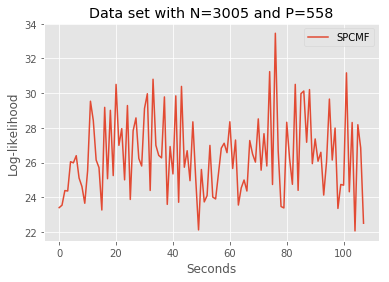

In [38]:
plt.plot(spcmf_ll[1], label='SPCMF')
plt.ylabel('Log-likelihood')
plt.xlabel('Seconds')
plt.title('Data set with N={} and P={}'.format(N, P))
plt.legend()
plt.show()

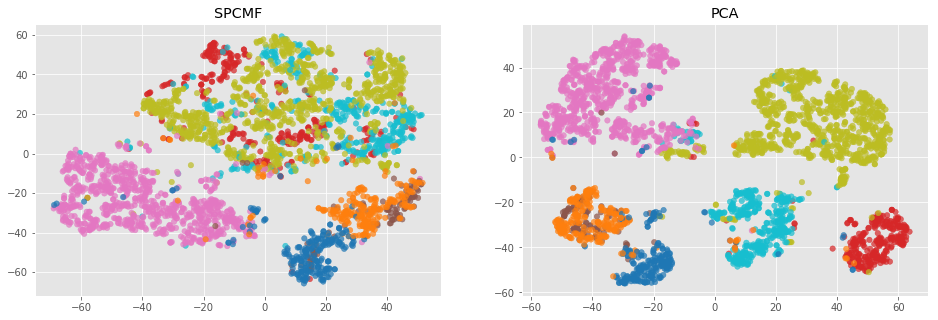

In [39]:
# Plot lower-dimensional embeddings
s = 30
alpha = 0.7

fig = plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.scatter(spcmf_U[:, 0], spcmf_U[:, 1], c=labels, cmap=plt.get_cmap("tab10", 7), s=s, alpha=alpha)
plt.title('SPCMF')

ax2 = plt.subplot(1, 2, 2)
ax2.scatter(pca_U[:, 0], pca_U[:, 1], c=labels, cmap=plt.get_cmap("tab10", 7), s=s, alpha=alpha)
plt.title('PCA')

plt.show()

In [40]:
spcmf_silh = silhouette_score(spcmf_U, labels)
pca_silh = silhouette_score(pca_U, labels)

scores = {'PCA': pca_silh, 'SPCMF': spcmf_silh}
sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

print('Silhouette scores (higher is better):')
print('1.\033[1m {0}: {1:.3}\033[0m'.format(sorted_scores[0][0], sorted_scores[0][1]))
i = 2
for score_tp in sorted_scores[1:]:
    print('{0}. {1}: {2:.3}'.format(i, score_tp[0], score_tp[1]))
    i += 1

Silhouette scores (higher is better):
1. PCA: 0.41
2. SPCMF: 0.139
